C:\Users\Kumar\AppData\Local\Temp\ipykernel_10880\1466387417.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stage', y='count', data=full_data_df, palette='Reds', width=0.1)


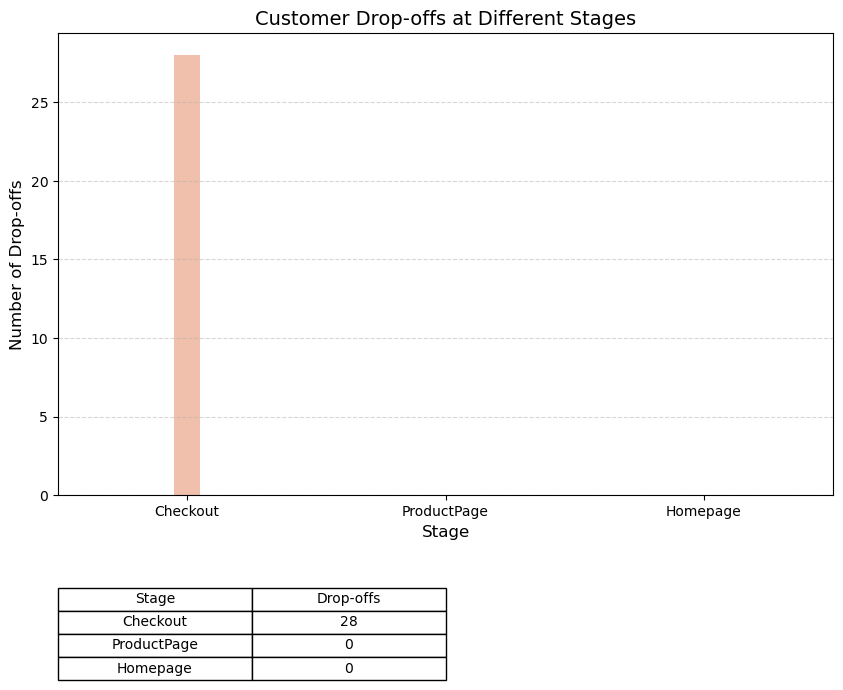

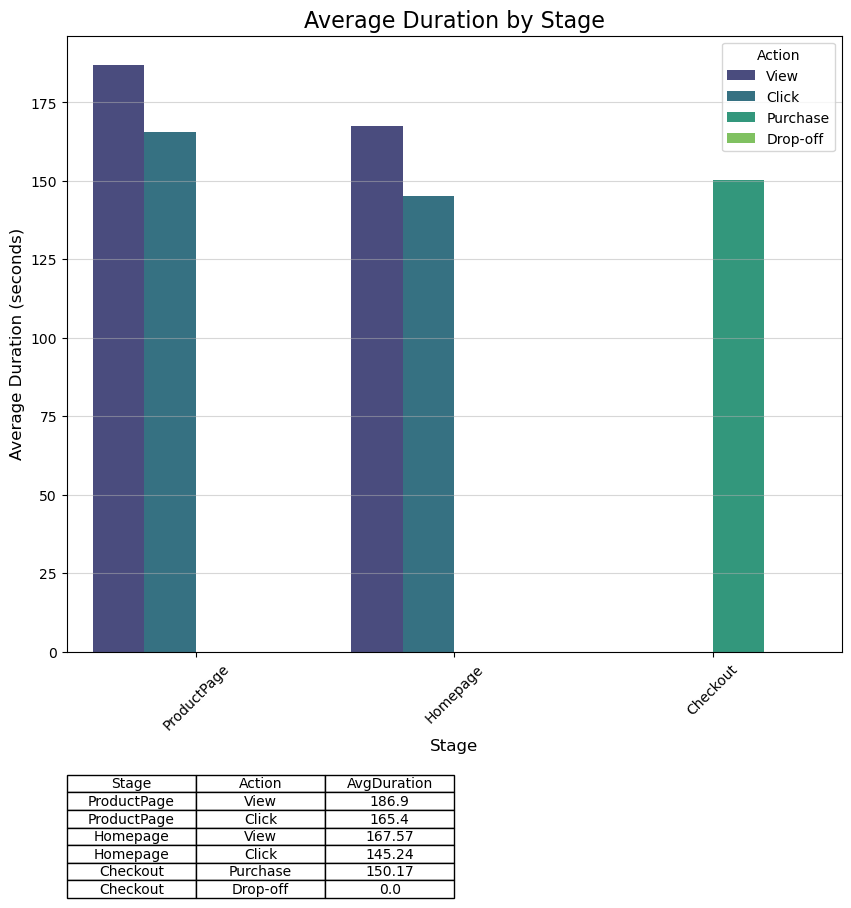

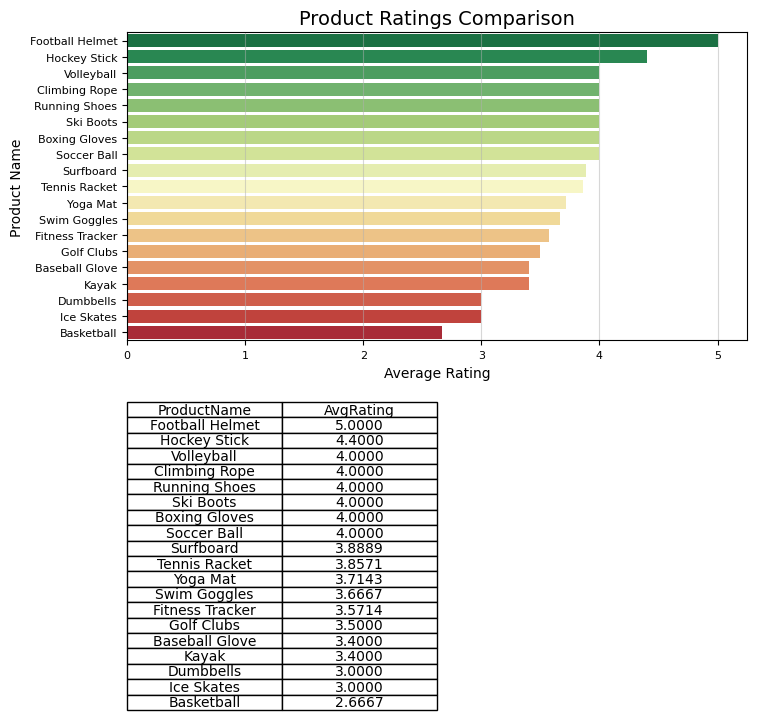

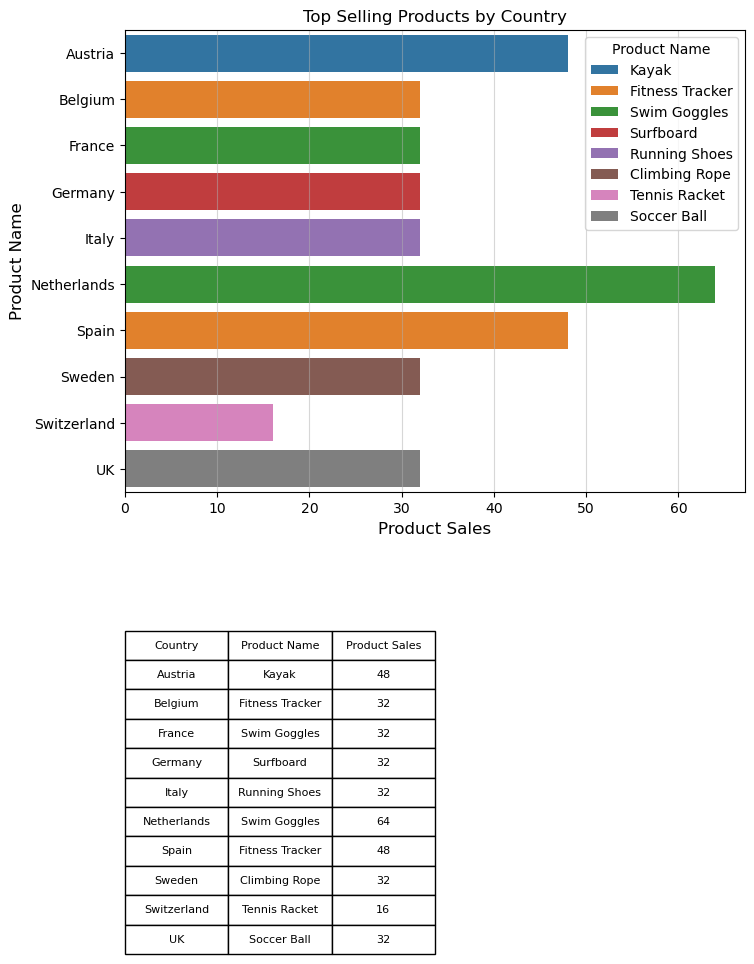

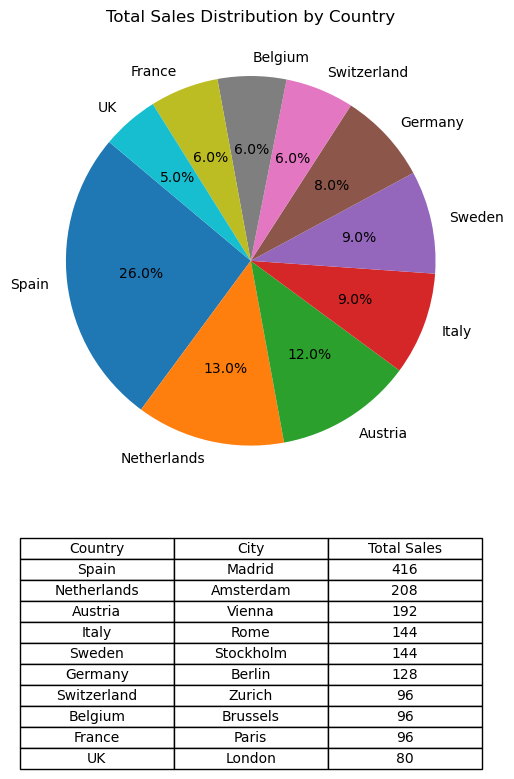

<Figure size 1200x600 with 0 Axes>

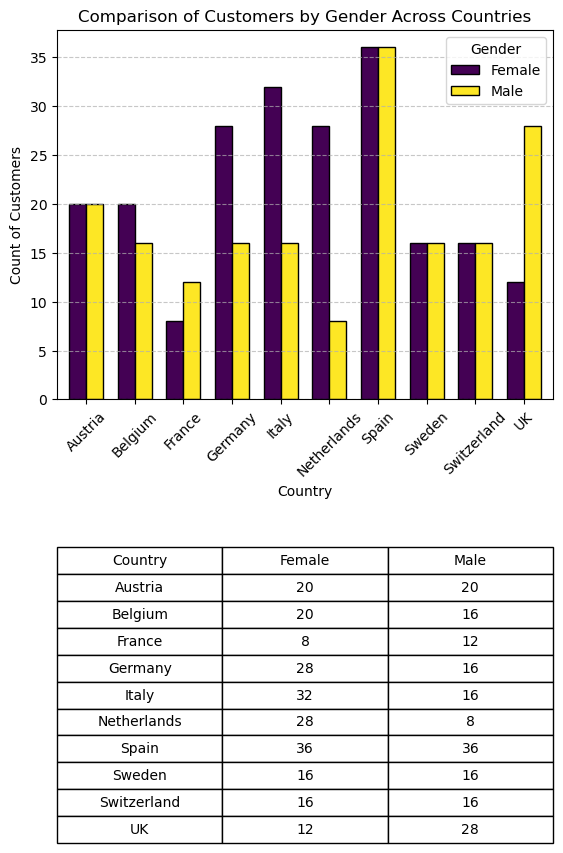

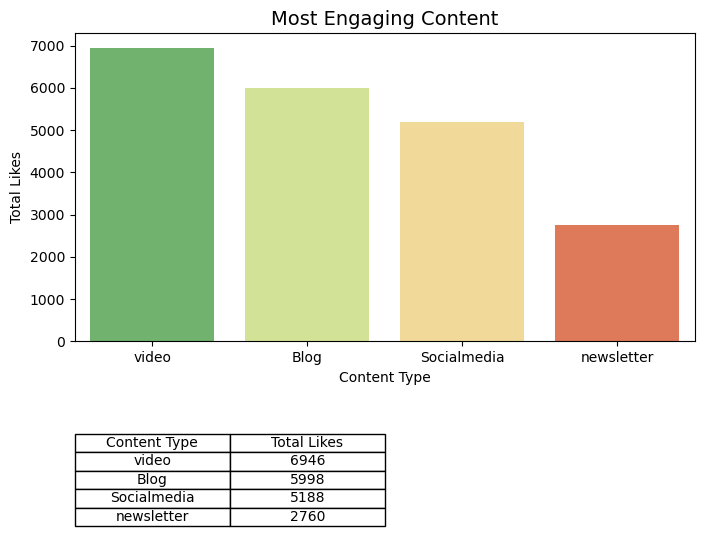

C:\Users\Kumar\AppData\Local\Temp\ipykernel_10880\1466387417.py:279: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product Name', y='Total Likes', data=most_liked_df, palette='coolwarm')


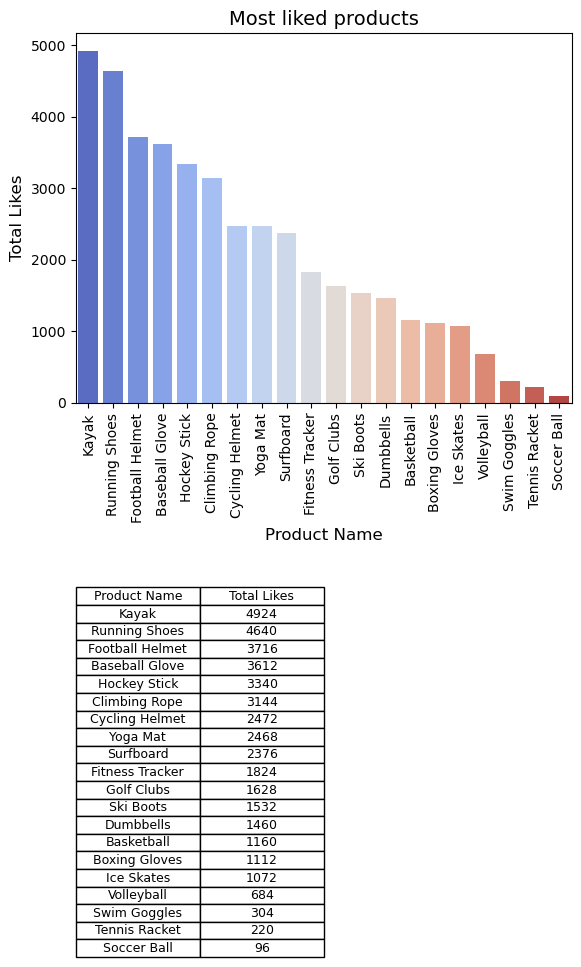

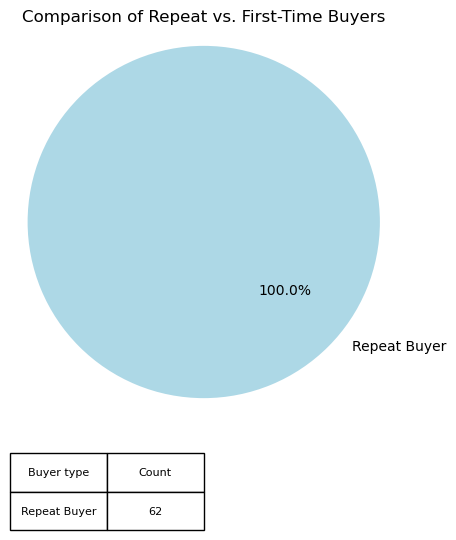

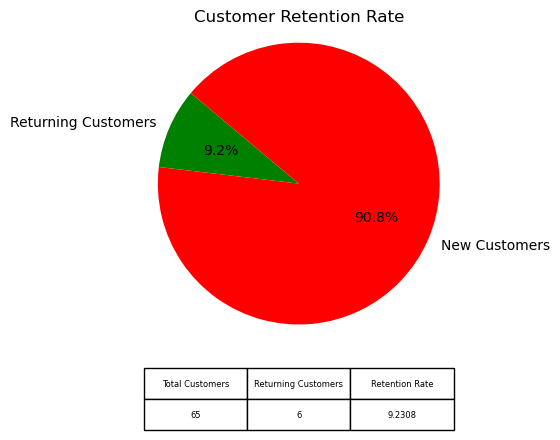

In [158]:
#Connect to MySQL Database & create database

!pip install pymysql
import pandas as pd
import pymysql
import os
import matplotlib.pyplot as plt
import seaborn as sns

myconnection = pymysql.connect(host="127.0.0.1",user="root",password="Selva765799#")

cursor=myconnection.cursor()

cursor.execute("CREATE DATABASE IF NOT EXISTS Project")

cursor.execute("use project")

#Define a Function to Create Tables

def create_table_from_dataframe(df, table_name): 

    dtype_mapping={
        'int64':'INTEGER',
        'float64':'FLOAT',
        'object':'TEXT',
        'bool':'BOOLEAN',
        'datetime64[ns]':'DATETIME',
    }    
    
    columns = ",".join(F"{col} {dtype_mapping[str(dtype)]}" for col,dtype in zip(df.columns,df.dtypes))
    
    cursor.execute(f"create table if not exists Project.{table_name} ({columns})")

#Define a Function to Insert Data into Tables

def insert_data_from_dataframe(df, table_name):
        insert_query = f"INSERT IGNORE INTO Project.{table_name} ({','.join(df.columns)}) VALUES ({','.join(['%s'] * len(df.columns))})"
        # Convert DataFrame to list of tuples for bulk insert
        data = [tuple(i) for i in df.values]
        
        # Bulk insert data into MySQL
        cursor.executemany(insert_query, data)
        myconnection.commit()
    

csv_directory = r"C:\Users\Kumar\Desktop\Customer Behavior Analysis"

# Iterate over all CSV files in the directory

for filename in os.listdir(csv_directory):
   if filename.endswith('.csv'):
       file_path = os.path.join(csv_directory, filename)
       df = pd.read_csv(file_path)

       # Replace NaN values with 0
       df = df.where(pd.notnull(df), 0)

       # Create table and insert data
       table_name = os.path.splitext(filename)[0]
       create_table_from_dataframe(df, table_name)
       insert_data_from_dataframe(df, table_name)


#Identify drop-off points in the customer journey

#Fetch all unique stages
cursor.execute("SELECT DISTINCT stage FROM customer_journey")
result = cursor.fetchall()
all_stages_df = pd.DataFrame(result, columns=['Stage'])

#Fetch drop-off counts
cursor.execute("""
    SELECT stage, COUNT(*) as Dropoffs 
    FROM customer_journey 
    WHERE action = "Drop-off" 
    GROUP BY stage;
""")
result = cursor.fetchall()
dropoff_points_df = pd.DataFrame(result, columns=['Stage', 'count'])

#Merge to include missing stages with 0 drop-offs
full_data_df = all_stages_df.merge(dropoff_points_df, on='Stage', how='left').fillna(0)

full_data_df['count'] = full_data_df['count'].astype(int)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Stage', y='count', data=full_data_df, palette='Reds', width=0.1)
plt.title('Customer Drop-offs at Different Stages', fontsize=14)
plt.xlabel('Stage', fontsize=12)
plt.ylabel('Number of Drop-offs', fontsize=12)
plt.grid(axis='y',linestyle='--',alpha=0.5)

#Display the table
table_data = list(zip(full_data_df['Stage'], full_data_df['count']))
plt.table(cellText=table_data, colLabels=['Stage', 'Drop-offs'], loc='bottom', cellLoc='center', bbox=[0, -0.40, 0.5, 0.2])

plt.show()

#Average duration per stage in customer journey

cursor.execute("""select stage,action,round(avg(duration),2) as AvgDuration from customer_journey
group by stage,action
order by stage desc , AvgDuration Desc;""")

result=cursor.fetchall()

avgduration_df=pd.DataFrame(result, columns=['Stage','Action','AvgDuration'])

# Plot the bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Stage', y='AvgDuration',hue='Action', data=avgduration_df, palette='viridis')
plt.title('Average Duration by Stage', fontsize=16)
plt.xlabel('Stage', fontsize=12)
plt.ylabel('Average Duration (seconds)', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.xticks(rotation=45)

#Display the table
table_data = list(zip(avgduration_df['Stage'], avgduration_df['Action'],avgduration_df['AvgDuration']))
plt.table(cellText=table_data, colLabels=['Stage', 'Action','AvgDuration'], loc='bottom', cellLoc='center', bbox=[0, -0.40, 0.5, 0.2])

plt.show()


#Identify highest-rated and lowest-rated products

cursor.execute("""Select distinct p.ProductID,p.ProductName,avg(r.Rating) as AvgRating 
from customer_reviews r left join products p on r.ProductID=p.productID
group by p.productID,p.productname
order by AvgRating Desc""")

result = cursor.fetchall()

ratings_df = pd.DataFrame(result, columns=['ProductID', 'ProductName', 'AvgRating'])

# Plot the bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='AvgRating', y='ProductName', data=ratings_df, hue='ProductName', palette='RdYlGn_r')
plt.title('Product Ratings Comparison', fontsize=14)
plt.xlabel('Average Rating', fontsize=10)
plt.ylabel('Product Name', fontsize=10)
plt.xticks(fontsize=8) 
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle='-', alpha=0.5)

#Display the table
table_data = list(zip(ratings_df['ProductName'], ratings_df['AvgRating']))
plt.table(cellText=table_data, colLabels=['ProductName', 'AvgRating'], loc='bottom', cellLoc='center', bbox=[0,-1.2, 0.5, 1])

plt.show()


#Best-performing products per region.

cursor.execute("""WITH RankedProducts AS (
    SELECT g.country,p.ProductName,COUNT(r.ProductID) AS product_sales,
	ROW_NUMBER() OVER (PARTITION BY g.country ORDER BY COUNT(r.ProductID) DESC) AS product_rank
    FROM customer_reviews r JOIN products p ON p.ProductID = r.ProductID
    JOIN Customers c ON c.CustomerID = r.CustomerID
    JOIN Geography g ON c.GeographyID = g.GeographyID
    GROUP BY g.country, p.ProductName
)
SELECT country,ProductName,product_sales
FROM RankedProducts
WHERE product_rank = 1;""")

result = cursor.fetchall()

top_selling_df = pd.DataFrame(result, columns=['Country','Product Name','Product Sales'])

# Plot a grouped bar chart 
plt.figure(figsize=(8,6))

sns.barplot(x='Product Sales', y='Country', hue='Product Name', data=top_selling_df,errorbar=None)
plt.grid(axis='x', linestyle='-', alpha=0.5)
plt.title('Top Selling Products by Country', fontsize=12)
plt.xlabel('Product Sales', fontsize=12)
plt.ylabel('Product Name', fontsize=12)

#Display the table
table_data = list(zip(top_selling_df['Country'], top_selling_df['Product Name'],top_selling_df['Product Sales']))
plt.table(cellText=table_data, colLabels=['Country', 'Product Name','Product Sales'], loc='bottom', cellLoc='center', bbox=[0,-1.0, 0.5, 0.7])

plt.show()


#Country wise sales performance

cursor.execute("""SELECT g.country,g.city,COUNT(r.ProductID) AS total_sales
    FROM customer_reviews r JOIN products p ON p.ProductID = r.ProductID
    JOIN Customers c ON c.CustomerID = r.CustomerID
    JOIN Geography g ON c.GeographyID = g.GeographyID
    GROUP BY g.country, g.city
    order by total_sales desc;""")

result=cursor.fetchall()

country_sales_df=pd.DataFrame(result,columns=['Country','City','Total Sales'])

#Plot the pie chart

plt.figure(figsize=(10, 6))
plt.pie(country_sales_df['Total Sales'], labels=country_sales_df['Country'], autopct='%1.1f%%',startangle=140)
plt.title('Total Sales Distribution by Country')

#Display the table 
table_data = list(zip(country_sales_df['Country'], country_sales_df['City'],country_sales_df['Total Sales']))
plt.table(cellText=table_data, colLabels=['Country', 'City','Total Sales'], loc='bottom', cellLoc='center', bbox=[0,-0.6, 1, 0.5])

plt.show() 

# Gender wise customers on each country

cursor.execute("""select g.country,c.gender, count(c.gender) as customers_count from customers c left join geography g on c.GeographyID=g.GeographyID
    group by g.Country,c.gender
    order by g.country;""")

result=cursor.fetchall()

customers_gender_df=pd.DataFrame(result,columns=['Country','Gender','Count of Customers'])

customers_gender_pivot = customers_gender_df.pivot(index='Country', columns='Gender', values='Count of Customers')

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
customers_gender_pivot.plot(kind='bar', colormap='viridis', width=0.7, edgecolor='black')
plt.title('Comparison of Customers by Gender Across Countries')
plt.xlabel('Country')
plt.ylabel('Count of Customers')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--',alpha=0.7)

# Display the table below the bar chart
table_data = customers_gender_pivot.reset_index().values.tolist()  
plt.table(cellText=table_data, colLabels=['Country'] + list(customers_gender_pivot.columns), loc='bottom', cellLoc='center', bbox=[0, -1.2, 1, 0.8])

plt.show()


# Most Engaging Content Type

cursor.execute("""select ContentType, sum(Likes) AS TotalLikes
from engagement_data
group by ContentType
order by TotalLikes desc;""")

result=cursor.fetchall()

content_df=pd.DataFrame(result, columns=['Content Type', 'Total Likes'])

#Plot the bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='Content Type',y='Total Likes',data=content_df,hue='Content Type',palette='RdYlGn_r')
plt.title("Most Engaging Content",fontsize=14)

#Display the table 
table_data = list(zip(content_df['Content Type'], content_df['Total Likes']))
plt.table(cellText=table_data, colLabels=['Content Type', 'Total Likes'], loc='bottom', cellLoc='center', bbox=[0, -0.60, 0.5, 0.3])

plt.show()


# Most liked product by people in marketing campaign

cursor.execute("""select p.ProductName, sum(e.Likes) AS TotalLikes
from engagement_data e
join products p on e.productID=p.productID
group by p.ProductName
order by TotalLikes desc;""")

result=cursor.fetchall()

most_liked_df=pd.DataFrame(result, columns=['Product Name','Total Likes'])

#Plot the bar chart

sns.barplot(x='Product Name', y='Total Likes', data=most_liked_df, palette='coolwarm')
plt.title('Most liked products in Marketing Campaign', fontsize=14)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Total Likes', fontsize=12)
plt.xticks(rotation=90)

#Display the table
table_data = list(zip(most_liked_df['Product Name'], most_liked_df['Total Likes']))
plt.table(cellText=table_data, colLabels=['Product Name', 'Total Likes'], loc='bottom', cellLoc='center', bbox=[0,-1.5, 0.5, 1])

plt.show()


#Compare repeat vs. first-time buyers.

cursor.execute("""WITH purchase_counts AS (
    SELECT customerid, COUNT(rating) AS total_purchases FROM customer_reviews
    GROUP BY customerid
)
SELECT 
    CASE 
    WHEN total_purchases = 1 THEN 'First-Time Buyer'ELSE 'Repeat Buyer'
    END AS Buyer_type,
    COUNT(customerid) AS count
FROM purchase_counts
GROUP BY buyer_type;""")

result=cursor.fetchall()

customers_df=pd.DataFrame(result,columns=['Buyer type','Count'])

# Plot the grouped bar chart
plt.figure(figsize=(5, 5))
plt.pie(customers_df['Count'], labels=customers_df['Buyer type'], autopct='%1.1f%%', startangle=140,colors=['lightblue', 'orange'])
plt.title('Comparison of Repeat vs. First-Time Buyers')
plt.axis('equal')

#Display the table
table_data = list(zip(customers_df['Buyer type'], customers_df['Count']))
plt.table(cellText=table_data, colLabels=['Buyer type', 'Count'], loc='bottom', cellLoc='center', bbox=[0,-0.3, 0.5, 0.2])

plt.show()


#Calculate customer retention rate

cursor.execute("""with returning_customers as (
    select distinct CustomerID
    from customer_journey
    where Stage = 'Checkout' and action = 'Purchase'
)
select 
    count( distinct cj.CustomerID) as TotalCustomers,
    COUNT(distinct r.CustomerID) as ReturningCustomers,
    (COUNT(distinct r.CustomerID) * 100 / COUNT(distinct cj.CustomerID)) as RetentionRate
from customer_journey cj
left join returning_customers r on cj.CustomerID = r.CustomerID;""")

result=cursor.fetchall()

retention_rate_df=pd.DataFrame(result,columns=['Total Customers','Returning Customers','Retention Rate'])

total_customers = retention_rate_df.loc[0, 'Total Customers']
returning_customers = retention_rate_df.loc[0, 'Returning Customers']
new_customers = total_customers - returning_customers

# Plot the Pie Chart
sizes = [returning_customers, new_customers]
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=['Returning Customers', 'New Customers'], autopct='%1.1f%%', colors=['green', 'red'], startangle=140)
plt.title('Customer Retention Rate')
plt.axis('equal')

#Display the table 
table_data = list(zip(retention_rate_df['Total Customers'], retention_rate_df['Returning Customers'],retention_rate_df['Retention Rate']))
table=plt.table(cellText=table_data, colLabels=['Total Customers', 'Returning Customers','Retention Rate'], loc='bottom', cellLoc='center', bbox=[0,-0.3, 1, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(6)

plt.show()

myconnection.commit()

# Close the cursor and connection
cursor.close()
myconnection.close()
